In [1]:
import numpy as np
import scipy.stats as ss
from numpy import Inf
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import sys
import pyEXP
from schwimmbad import SerialPool,MultiPool
##  exp
#sys.path.append("/u/svarel/exp/build/utils/Analysis/")
from spherical_basis_builder import *
#import simpleSL

## Auriga
import LibAu as la
#import warnings
#warnings.filterwarnings('ignore')

In [2]:
def EBF(R,basis):
    lrmin = np.log10(np.nanmin(R))
    lrmax = np.log10(np.nanmax(R))
    rnum  = len(R) 
    basis_grid = basis.getBasis(lrmin, lrmax, rnum)


    r = np.linspace(lrmin, lrmax, rnum)
    r = np.power(10.0, r)


    for l in range(6):
        for n in range(10):
            plt.semilogx(r, basis_grid[l][n], '-', label="n={}".format(n))
        plt.xlabel('r')
        plt.ylabel('potential')
        plt.title('l={}'.format(l))
        plt.legend()
        plt.show()

Au-16 snapshot 40


/u/svarel/.local/lib/python3.6/site-packages/cosmological_factors.py:100: RuntimeWarning: invalid value encountered in sqrt
  var2 = np.sqrt(self.OmegaLambda / self.OmegaMatter * a**3.0)


! Scaling:  R= 193.13716406422787   M= 1.0
0.9999999999999999 5.1918416250270035e-08 5.1918416250270035e-08 5.1918416250270035e-08
Au-16 snapshot 63


/u/svarel/.local/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: divide by zero encountered in log10
/u/svarel/.local/lib/python3.6/site-packages/cosmological_factors.py:100: RuntimeWarning: invalid value encountered in sqrt
  var2 = np.sqrt(self.OmegaLambda / self.OmegaMatter * a**3.0)


! Scaling:  R= 575.9432091934026   M= 1.0
1.0 3.298520049294974e-08 3.298520049294975e-08 3.298520049294975e-08


/u/svarel/.local/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: divide by zero encountered in log10


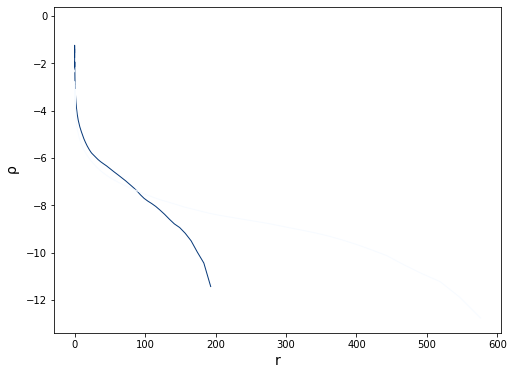

In [3]:
nhalo = 16
Lsnap = np.arange(39,64,1,dtype=int)
colors = pl.cm.Blues(np.linspace(0,1,len(Lsnap)))[::-1]

plt.figure(figsize=(8,6))
RL,DL = [],[]
Datapos = {}
for ii,ns in enumerate(Lsnap):
    if ns not in (63,40): continue
    print('Au-%s snapshot %s'%(nhalo,ns))
    
    sim = la.Reader_Au(Nhalo=nhalo,Nsnap=ns)
    #print(sim.base)
    
    header = sim.Header()
    h=header['hubbleparam']
    sc=header['time']
    
    Rvir =sim.sf.data['frc2'][0]*1000*sc/h #[kpc] 
    Mvir =sim.sf.data['fmc2'][0]*1e10/h    #[Msun]
    
    try:
        fields_stars = ['pos','vel','id','mass','type','pot','age']
        Datstars = sim.Snapshot_Subhalo(idSubhalo=0,snapType='stars',fields=fields_stars)
    except KeyError:
        fields_stars = ['pos','vel','id','mass','type','pot']
        Datstars = sim.Snapshot_Subhalo(idSubhalo=0,snapType='stars',fields=fields_stars)

    fields_dm = ['pos','vel','id','mass','type','pot']
    DatDM = sim.Snapshot_Subhalo(idSubhalo=0,snapType='dm1',fields=fields_dm)
    
    #Rotate Halo---------------------------------------------------------------------
    Data = {'stars':Datstars,'dm1':DatDM}
    param = {'spos':sim.sf.data['spos'][0,:],'svel':sim.sf.data['svel'][0,:],'header':sim.Header()}
    gal = la.ToolRot(Data=Data, param=param)
    Data = gal.Centered()#gal.Rotate()

    Datstars=Data['stars']
    DatDM = Data['dm1']
    #--------------------------------------------------------------------------------

    potdm = np.float64(DatDM['pot'])
    pos = np.float64(DatDM['pos']) #part_rot[not_in_subs]
    mass = np.float64(np.ones_like(pos[:,0]))#DatDM['mass']  #part['dark']['mass'][not_in_subs]

    poss,masss=Datstars['pos'],Datstars['mass']
    #print(type(mass[0]))
    
    rr = np.sqrt((pos[:,0]**2) + (pos[:,1]**2) + (pos[:,2]**2))
    
    binrad = 200
    
    rrmin,rrmax=np.nanmin(np.log10(rr)),np.nanmax(np.log10(rr))
    r,rho = return_density(np.log10(rr),weights= 1., rangevals=[rrmin, rrmax],bins=binrad)
    
    
    R,D,M,P = makemodel_empirical(r, rho, "Au{}_table.txt".format(nhalo))
    
    plt.plot(R,np.log10(D),color=colors[ii],lw=1)#,zorder=ns)
    RL.append(R)
    DL.append(D)
    if ns in (63,40):Datapos['Snap'+str(ns)]=pos
plt.ylabel(r'$\rm \rho$',fontsize=14)
plt.xlabel(r'r',fontsize=14)

plt.show()
RL,DL = np.array(RL),np.array(DL)

In [4]:
Rbin = np.linspace(np.nanmin(RL),np.nanmax(RL),50)
Rhomed = np.zeros_like(Rbin)
for i,rb in enumerate(Rbin):
    if rb==Rbin[-1]:continue
    sel = (Rbin[i]<=RL)&(RL<Rbin[i+1])
    Rhomed[i]= np.median(DL[sel])

/u/svarel/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/u/svarel/.local/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


/u/svarel/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys
/u/svarel/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys


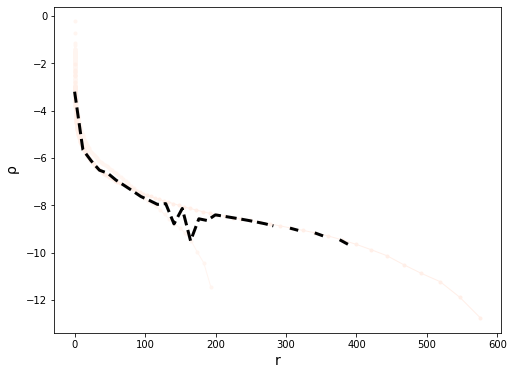

In [5]:
colors = pl.cm.Reds(np.linspace(0,1,27))#[::-1]
count=0
plt.figure(figsize=(8,6))
for kk,k_ in enumerate(zip(DL,RL)):
    #print(kk)
    d_,r_=k_
    plt.plot(r_,np.log10(d_),color=colors[count],marker='.',lw=1,zorder=count)
    count+=1
plt.plot(Rbin[:-1],np.log10(Rhomed[:-1]),color='k',ls='--',lw=3,zorder=count+1)
plt.ylabel(r'$\rm \rho$',fontsize=14)
plt.xlabel(r'r',fontsize=14)

plt.show()

In [6]:
RL

array([[6.49028311e-03, 6.83508712e-03, 7.19820925e-03, 7.58062268e-03,
        7.98335228e-03, 8.40747737e-03, 8.85413460e-03, 9.32452104e-03,
        9.81989731e-03, 1.03415910e-02, 1.08910004e-02, 1.14695977e-02,
        1.20789337e-02, 1.27206415e-02, 1.33964407e-02, 1.41081425e-02,
        1.48576544e-02, 1.56469849e-02, 1.64782496e-02, 1.73536762e-02,
        1.82756109e-02, 1.92465245e-02, 2.02690190e-02, 2.13458347e-02,
        2.24798576e-02, 2.36741268e-02, 2.49318429e-02, 2.62563767e-02,
        2.76512780e-02, 2.91202850e-02, 3.06673348e-02, 3.22965734e-02,
        3.40123673e-02, 3.58193148e-02, 3.77222585e-02, 3.97262984e-02,
        4.18368052e-02, 4.40594353e-02, 4.64001452e-02, 4.88652081e-02,
        5.14612304e-02, 5.41951695e-02, 5.70743523e-02, 6.01064952e-02,
        6.32997242e-02, 6.66625974e-02, 7.02041272e-02, 7.39338050e-02,
        7.78616263e-02, 8.19981178e-02, 8.63543654e-02, 9.09420437e-02,
        9.57734480e-02, 1.00861526e-01, 1.06219915e-01, 1.118629

In [7]:
R0,D0,M0,P0 = makemodel_empirical(RL[-1], DL[-1], "Au{}_Snap{}_table.txt".format(nhalo,63))
config0="""
---
id: sphereSL
parameters :
  numr: %s
  rmin: %s
  rmax: %s
  Lmax: 6
  nmax: 20
  modelname: %s_%s_table.txt
...
"""%(len(R0),round(np.nanmin(R0),3), round(np.nanmax(R0),3),'Au'+str(nhalo),'Snap'+str(63))
print(config0)

! Scaling:  R= 575.9432091934026   M= 1.0
1.0 0.9999999999999992 0.9999999999999993 0.9999999999999993

---
id: sphereSL
parameters :
  numr: 200
  rmin: 0.017
  rmax: 575.943
  Lmax: 6
  nmax: 20
  modelname: Au16_Snap63_table.txt
...



In [8]:
R39,D39,M39,P39 = makemodel_empirical(RL[0], DL[0], "Au{}_Snap{}_table.txt".format(nhalo,39))
config39="""
---
id: sphereSL
parameters :
  numr: %s
  rmin: %s
  rmax: %s
  Lmax: 6
  nmax: 20
  modelname: %s_%s_table.txt
...
"""%(len(R39),round(np.nanmin(R39),3), round(np.nanmax(R39),3),'Au'+str(nhalo),'Snap'+str(39))
print(config39)

! Scaling:  R= 193.13716406422785   M= 1.0
1.0 0.9999999999999997 0.9999999999999998 0.9999999999999998

---
id: sphereSL
parameters :
  numr: 200
  rmin: 0.006
  rmax: 193.137
  Lmax: 6
  nmax: 20
  modelname: Au16_Snap39_table.txt
...



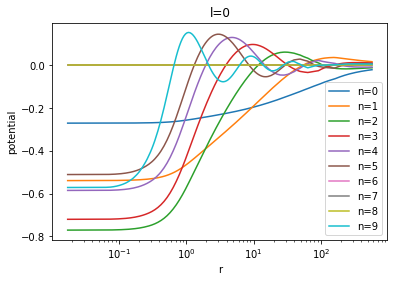

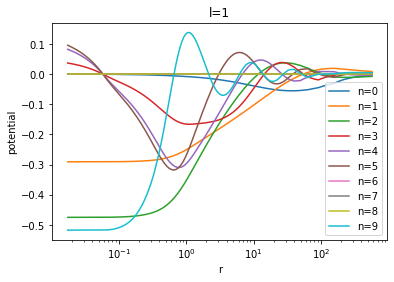

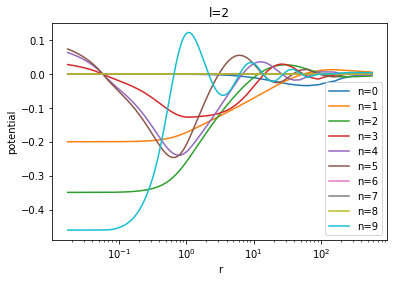

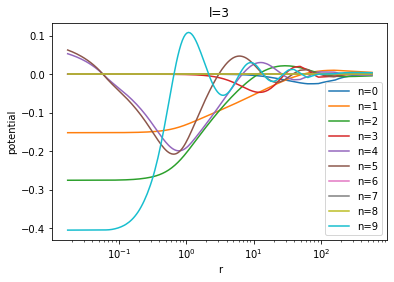

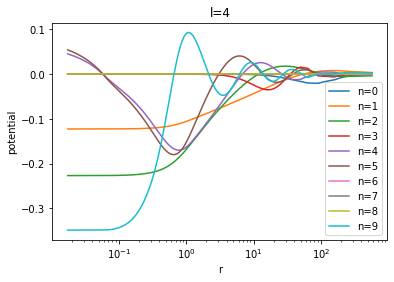

In [ ]:
def func(rs,ii):
    basis = pyEXP.basis.Basis.factory(ii)
    EBF(rs,basis)
for ii,rs in [(config0,R0),(config39,R39)]:
    func(rs,ii)
    #del basis

In [ ]:
basis39 = pyEXP.basis.Basis.factory(config39)

In [ ]:
EBF(R0,basis0)

In [ ]:
EBF(R39,basis39)

In [ ]:
def BuildFields(args):
    
    conf,ns = args
    basis = pyEXP.basis.Basis.factory(config0)
    def GetFields(coords):
        dens0,potl0,dens,potl,fx,fy,fz = basis.getFields(x=coords[0],y=coords[1],z=coords[2])
        return dens0,dens,potl0,potl
    
    pool = SerialPool()
    Fields = np.array(list(pool.map(GetFields, pos )))
    
    den0, den1,pot0,pot1 = values[:,0], values[:,1], values[:,2], values[:,3]
    rpos =  np.sqrt(pos[:,0]**2 + pos[:,1]**2 + pos[:,2]**2)
    M0,M1 = den0*((4*np.pi*rpos**3)/3),den1*((4*np.pi*rpos**3)/3)
    
    den0, den1,pot0,pot1 = np.array(Fields[:,0]),np.array(Fields[:,1]),np.array(Fields[:,2]),np.array(Fields[:,3])
    
    Npx=50


    Hden,Hpot,Hpotmed = np.zeros((Npx,Npx)),np.zeros((Npx,Npx)),np.zeros((Npx,Npx))
    den_mon,den_nonmon = np.zeros((Npx,Npx)),np.zeros((Npx,Npx))
    pot_mon,pot_nonmon = np.zeros((Npx,Npx)),np.zeros((Npx,Npx))
    xb,yb=np.linspace(pos[:,0].min(), pos[:,0].max(),Npx),np.linspace(pos[:,1].min(), pos[:,1].max(),Npx)
    dx,dy= xb[1]-xb[0],yb[1]-yb[0]
    xgrid, ygrid = np.meshgrid(xb, yb)

    rbord = np.argsort(rr)
    rb,mb = rr[rbord],mass[rbord]
    rbord1=np.argsort(rbord)
    mbacc = np.cumsum(mb)
    Pot_au=  ((-mbacc/rb) - (np.sum(mb/rb)-np.cumsum(mb/rb)))[rbord1]

    for j in range(yb.size -1):
        for i in range(xb.size-1):
            sel = (xb[i]<=pos[:,0])&(pos[:,0]<=xb[i+1]) & (yb[j]<=pos[:,1])&(pos[:,1]<=yb[j+1])
            if len(pos[:,2][sel])>0:
                dz = np.nanmax(pos[:,2][sel])-np.nanmin(pos[:,2][sel])
                Hden[j][i] = np.sum(mass[sel])/(dx*dy*dz)
                den_mon[j][i],den_nonmon[j][i]=np.median(den0[sel]),np.median(den1[sel])
            
                Hpot[j][i] = np.sum(Pot_au[sel])/(dx*dy*dz)#potdm
                Hpotmed[j][i] = np.median(Pot_au[sel])#potdm
                pot_mon[j][i],pot_nonmon[j][i]=np.median(pot0[sel]),np.median(pot1[sel])
            else: pass
            
    #------------------------------------------------------------------------
    
    km2kpc=3.24078e-17

    Hpot_= np.log10(np.abs( Hpotmed))#* (rbins[-1]/(G*Macc[-1]) )    ))

    fig, ax = plt.subplots(1, 3, figsize=(25,6))
    extent = xb.min(),xb.max(),yb.min(),yb.max()
    im = ax[0].imshow(Hpot_,extent=extent,aspect='auto',origin='lower',interpolation='none',cmap='gist_stern')
    plt.colorbar(im, ax=ax[0],label='Potential')
    #im.set_clim(7,12)
    ax[0].set_title('Input Data',fontsize=18)
    #*(rbins[-1]/(Macc[-1]) ) 
    #im2 = ax[1].contourf(xgrid, ygrid, np.log10(np.abs(den_mon + den_nonmon)),40,cmap='gist_stern')
    im2 = ax[1].imshow(np.log10(np.abs(pot_mon + pot_nonmon)),extent=extent,aspect='auto',origin='lower',interpolation='none',cmap='gist_stern')
    plt.colorbar(im2, ax=ax[1],label='Potential')
    im2.set_clim(im.get_clim()[0],im.get_clim()[1])
    ax[1].set_title('Potential Field Reconstruction',fontsize=18)


    potresidual = (Hpotmed - (pot_mon + pot_nonmon))/Hpotmed

    #im3 = ax[2].imshow(denmask,extent=extent,aspect='auto',origin='lower',interpolation='none',cmap='gist_stern')
    im3 = ax[2].contourf(xgrid, ygrid, potresidual,50,cmap='gist_stern')
    plt.colorbar(im3, ax=ax[2],label='Potential')
    #im3.set_clim(7,12)
    for i_ in [0,1,2]:
        ax[i_].set_xlabel('x kpc',fontsize=15)
        ax[i_].set_ylabel('y kpc',fontsize=15)
    plt.subplots_adjust(wspace=0.1)
    ax[2].set_title('Residual',fontsize=18)
    plt.savefig('plots/PotEXP_Au%s_Snap&s.png'%(str(nhalo),str(ns)))
    plt.show()

    plt.close()
    return 1

In [ ]:
pool = MultiPool()
args=[[basis0,63],[basis39,39]]
ret = np.array(list(pool.map(BuildFields, args )))
pool.close()
